# Qualitative Inpainting Demo

Runs both vanilla and improved DDPM inpainting on your own images and displays results side-by-side.

**Setup:** Drop files into `my_images/` following the naming convention:
```
my_images/
  photo.png
  photo_mask.png    ← white = inpaint, black = keep
  cat.jpg
  cat_mask.png
```

In [1]:
# Cell 1 — Imports & config
import sys, os, warnings
import torch
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", message="IProgress not found")
from tqdm.auto import tqdm
from utils.image import apply_mask_for_display
from utils.cli import preprocess_inputs, load_sd_pipeline

STEPS          = 50
GUIDANCE_SCALE = 7.5
SEED           = 42
RESAMPLE_STEPS = 5
MY_IMAGES_DIR  = './our_images'

W0226 18:22:50.230000 10106 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/roeikasuss/miniconda3/envs/inpainting-env/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Cell 2 — Discover image/mask pairs; auto-generate missing masks from MNIST
import json
import torchvision
import numpy as np
from utils.image import prepare_mnist_mask

MNIST_SEED = 99  # separate seed so mask generation is reproducible

_mnist     = torchvision.datasets.MNIST(root='./data', train=False, download=True)
_rng       = np.random.RandomState(MNIST_SEED)

pairs = []          # (image_path, mask_path, stem, prompt)
needs_prompt = []   # stems where the user still needs to fill in a prompt

for f in sorted(os.listdir(MY_IMAGES_DIR)):
    stem, ext = os.path.splitext(f)
    if stem.endswith('_mask') or ext.lower() not in ('.png', '.jpg', '.jpeg'):
        continue

    img_path = os.path.join(MY_IMAGES_DIR, f)

    # --- locate or generate mask ---
    mask_path = None
    for mask_ext in ('.pt', '.png', '.jpg', '.jpeg'):
        candidate = os.path.join(MY_IMAGES_DIR, stem + '_mask' + mask_ext)
        if os.path.exists(candidate):
            mask_path = candidate
            break

    if mask_path is None:
        # Generate a random MNIST digit mask and save as .pt
        digit_idx   = int(_rng.randint(0, len(_mnist)))
        digit_img   = _mnist[digit_idx][0]
        mask_tensor = prepare_mnist_mask(digit_img)   # (1,1,512,512) float32
        mask_path   = os.path.join(MY_IMAGES_DIR, stem + '_mask.pt')
        torch.save(mask_tensor, mask_path)
        print(f'  [auto-mask] {stem}: generated MNIST digit mask → {stem}_mask.pt')

    # --- locate or stub prompt json ---
    json_path = os.path.join(MY_IMAGES_DIR, stem + '.json')
    if not os.path.exists(json_path):
        with open(json_path, 'w') as jf:
            json.dump({'caption': ''}, jf)
        needs_prompt.append(stem)
        print(f'  [stub json] {stem}: created {stem}.json — fill in "caption" before running Cell 5')

    with open(json_path) as jf:
        caption = json.load(jf).get('caption', '').strip()

    pairs.append((img_path, mask_path, stem, caption))

print(f'\nFound {len(pairs)} image/mask pair(s):')
for _, _, stem, caption in pairs:
    status = '(no prompt yet — edit json)' if not caption else f'"{caption}"'
    print(f'  {stem}: {status}')

if needs_prompt:
    print(f'\n⚠  Fill in the "caption" field in: {[s + ".json" for s in needs_prompt]}')
    print('   Then re-run this cell before running Cell 5.')


Found 3 image/mask pair(s):
  0000: "A large building with a clock at the top of it ."
  Roei-Room: "a bed with blue satin sheets"
  Work-Kitchen: (no prompt yet — edit json)


In [3]:
# Cell 3 — Load model
sys.path.insert(0, os.path.abspath('.'))
from vanilla_inpaint import ddpm_inpaint
from improved_inpaint import ddpm_inpaint_improved

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f'Using device: {device}')
pipe = load_sd_pipeline(device)
pipe.set_progress_bar_config(disable=True)
print('Model loaded.')

Using device: mps


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 26.86it/s]


Model loaded.


  0000: using existing prompt "A large building with a clock at the top of it ."
  Roei-Room: using existing prompt "a bed with blue satin sheets"


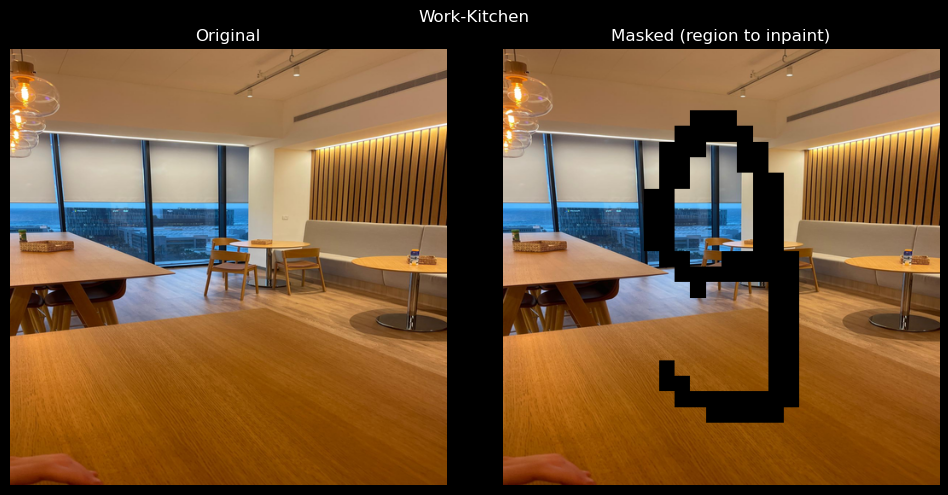

  -> saved "a work dining area at a hitech company" to Work-Kitchen.json



In [4]:
# Cell 4 — Interactive prompt collection (only for pairs with empty captions)
import json

for img_path, mask_path, stem, caption in pairs:
    if caption:
        print(f'  {stem}: using existing prompt "{caption}"')
        continue

    image_preview, mask_preview = preprocess_inputs(img_path, mask_path)
    masked_vis = apply_mask_for_display(image_preview, mask_preview)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_preview); axes[0].set_title('Original')
    axes[1].imshow(masked_vis);    axes[1].set_title('Masked (region to inpaint)')
    for ax in axes:
        ax.axis('off')
    plt.suptitle(stem, fontsize=12)
    plt.tight_layout()
    plt.show()

    prompt = input(f'Prompt for "{stem}" (leave blank for unconditional): ').strip()

    # Persist to json so the prompt survives kernel restarts
    json_path = os.path.join(MY_IMAGES_DIR, stem + '.json')
    with open(json_path, 'w') as jf:
        json.dump({'caption': prompt}, jf)
    print(f'  -> saved "{prompt}" to {stem}.json\n')

# Reload pairs with up-to-date captions
pairs = [
    (img_path, mask_path, stem,
     json.load(open(os.path.join(MY_IMAGES_DIR, stem + '.json'))).get('caption', ''))
    for img_path, mask_path, stem, _ in pairs
]

Inpainting:   0%|          | 0/3 [00:00<?, ?it/s]

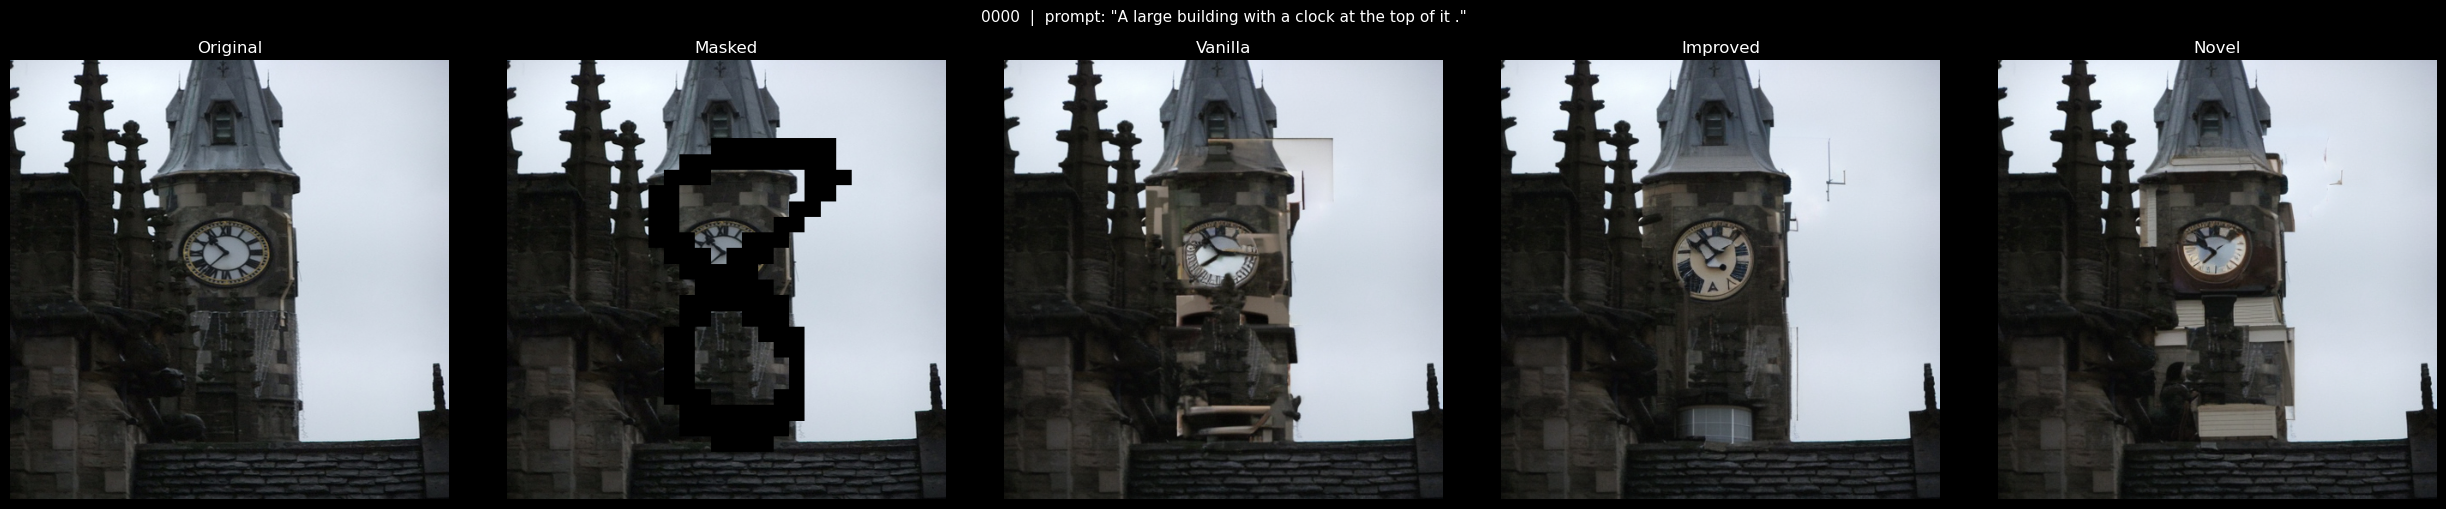

Inpainting:  33%|███▎      | 1/3 [01:12<02:25, 72.86s/it]

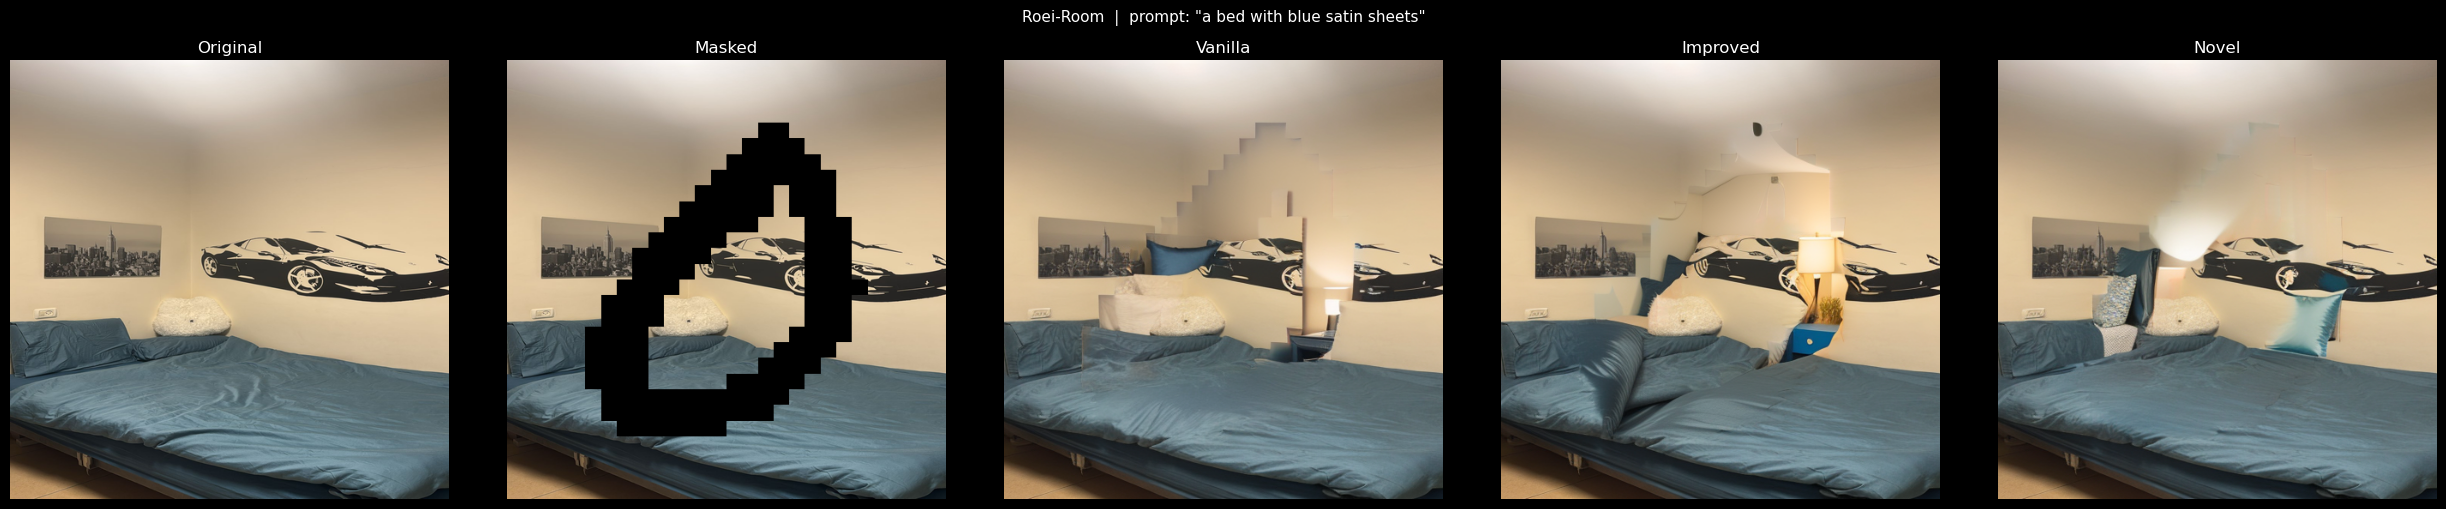

Inpainting:  67%|██████▋   | 2/3 [02:27<01:13, 73.76s/it]

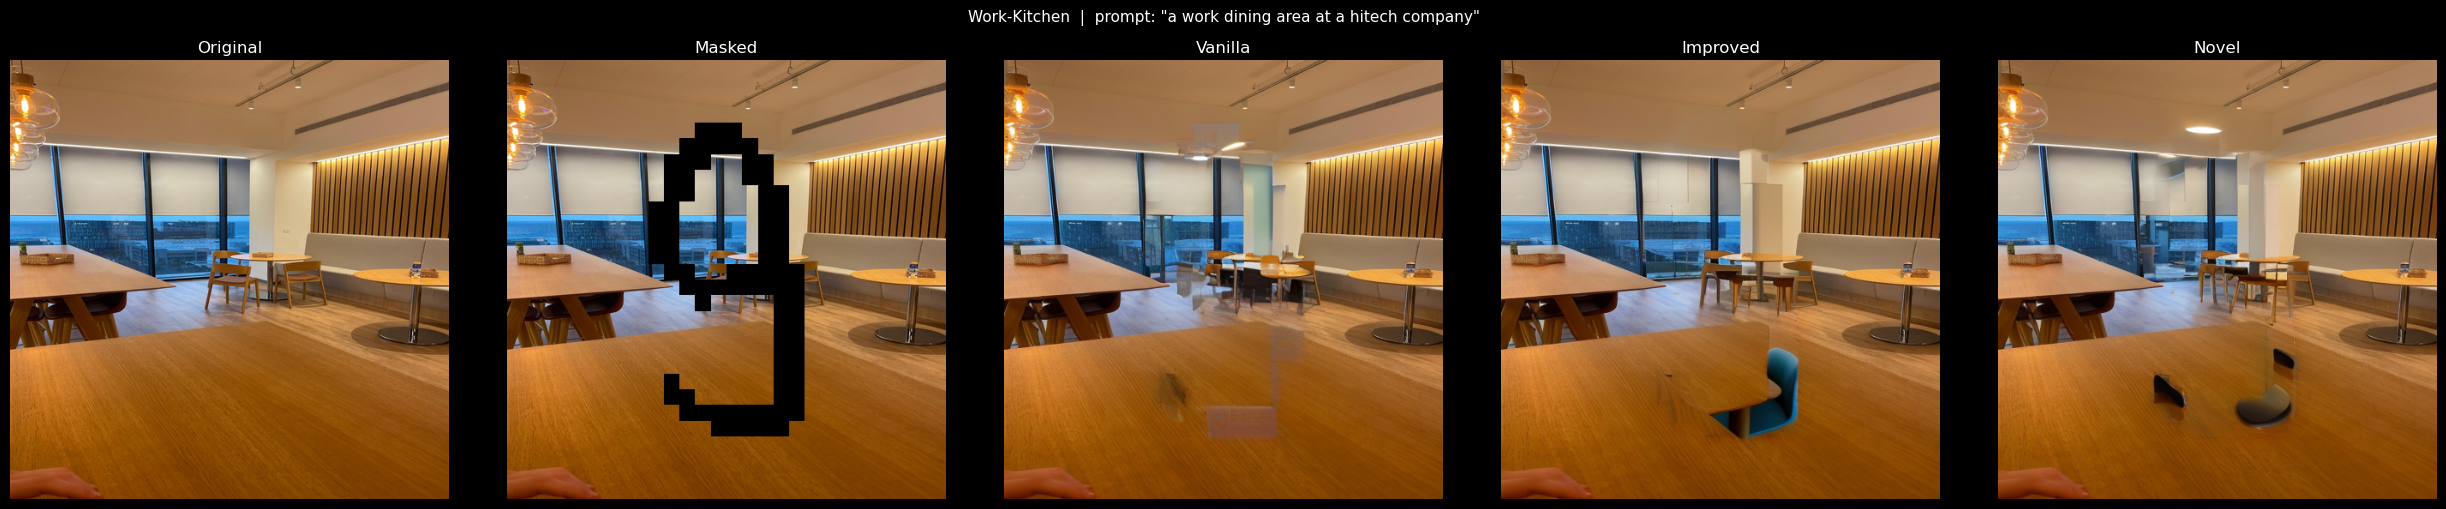

Inpainting: 100%|██████████| 3/3 [03:39<00:00, 73.09s/it]


In [5]:
# Cell 5 — Run inpainting & display side-by-side (Vanilla | Improved | Novel)
from novel_inpaint import ddpm_inpaint_novel

MAX_RADIUS  = 10
DECAY_STEPS = 35

assert all(caption for _, _, stem, caption in pairs), \
    'Some images have no prompt — run Cell 4 first.'

for img_path, mask_path, stem, prompt in tqdm(pairs, desc='Inpainting'):
    image, mask = preprocess_inputs(img_path, mask_path)

    van = ddpm_inpaint(pipe, image, mask, prompt, STEPS, GUIDANCE_SCALE, SEED)
    imp = ddpm_inpaint_improved(pipe, image, mask, prompt, STEPS, GUIDANCE_SCALE, SEED, RESAMPLE_STEPS)
    nov = ddpm_inpaint_novel(pipe, image, mask, prompt, STEPS, GUIDANCE_SCALE, SEED, MAX_RADIUS, DECAY_STEPS)

    masked_vis = apply_mask_for_display(image, mask)

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes[0].imshow(image);      axes[0].set_title('Original')
    axes[1].imshow(masked_vis); axes[1].set_title('Masked')
    axes[2].imshow(van);        axes[2].set_title('Vanilla')
    axes[3].imshow(imp);        axes[3].set_title('Improved')
    axes[4].imshow(nov);        axes[4].set_title('Novel')
    for ax in axes:
        ax.axis('off')
    plt.suptitle(f'{stem}  |  prompt: "{prompt}"', fontsize=11, y=1.01)
    plt.tight_layout()
    plt.show()